In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install transformers
import torch
import torch.nn as nn
import numpy as np
from transformers import ViTModel
from transformers import ViTModel, ViTConfig
from torch.optim import Adam
from tqdm import tqdm
import os
from skimage.transform import resize
from skimage.io import imread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

TRAIN_INDICES_FILE = 'train_indices.txt'
TEST_INDICES_FILE = 'test_indices.txt'

In [ ]:
!unzip /content/drive/MyDrive/MRIdataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: MRIdataset/Non_Demented/non_1757.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_1757.jpg  
  inflating: MRIdataset/Non_Demented/non_3168.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_3168.jpg  
  inflating: MRIdataset/Non_Demented/non_2276.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_2276.jpg  
  inflating: MRIdataset/Non_Demented/non_1019.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_1019.jpg  
  inflating: MRIdataset/Non_Demented/non_683.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_683.jpg  
  inflating: MRIdataset/Non_Demented/non_2510.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_2510.jpg  
  inflating: MRIdataset/Non_Demented/non_2504.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_2504.jpg  
  inflating: MRIdataset/Non_Demented/non_697.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_697.jpg  
  inflating: MRIdataset/Non_Demented/non_2262.jpg  
  inf

In [ ]:
# from datasets import load_dataset
# Load dataset
import os
DIR = '/content/MRIdataset'
os.path.exists(DIR)
os.listdir(DIR)
data_dir='/content/MRIdataset'

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, images, labels,transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.4914, 0.4822, 0.4465],
                    std=[0.2023, 0.1994, 0.2010],
                ),
            ])


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# your loading code
Categories=['Mild_Demented','Moderate_Demented','Very_Mild_Demented','Non_Demented']
flat_data_arr=[] #input array
target_arr=[] #output array
!pip install -q datasets

from datasets import load_dataset
import os

# Load dataset

for i in Categories:
    print(f'loading... category : {i}')
    path=os.path.join(data_dir,i)
    cnt = 0
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        # print(img_array.shape)
        img_resized=resize(img_array,(224,224,3))
        img_resized = np.transpose(img_resized, (2, 0, 1))
        flat_data_arr.append(img_resized)
        target_arr.append(Categories.index(i))
        cnt = cnt + 1
        # if cnt > 50: break
    print(f'loaded category:{i} successfully')

# # convert your data to tensors
flat_data_arr = [torch.from_numpy(img).float() for img in flat_data_arr]
target_arr = torch.tensor(target_arr, dtype=torch.long)
torch.cuda.is_available()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
loading... category : Mild_Demented
loaded category:Mild_Demented successfully
loading... category : Moderate_Demented
loaded category:Moderate_Demented successfully
loading... category : Very_Mild_Demented
loaded category:Very_Mild_Demented successfully
loading... category : Non_Demented
loaded category:Non_Demented successfully


True

In [ ]:
np.shape(target_arr)

torch.Size([6400])

In [ ]:
import os

with open(os.path.join('/content/drive/MyDrive/', TRAIN_INDICES_FILE), 'r') as f:
    train_indices = f.readlines()

with open(os.path.join('/content/drive/MyDrive/', TEST_INDICES_FILE), 'r') as f:
    test_indices = f.readlines()

# train_indices = np.arange(0,150)
# test_indices = np.arange(150,203)

print("training data size: ", len(train_indices))
print("testing data size: ", len(test_indices))
print(len(flat_data_arr))

### double check no overlap between train and test
for i in train_indices:
    if i in test_indices:
        print("overlap")
train_data = [flat_data_arr[int(i)] for i in train_indices]
test_data = [flat_data_arr[int(i)] for i in test_indices]
train_target = [target_arr[int(i)] for i in train_indices]
test_target = [target_arr[int(i)] for i in test_indices]

train_dataset = MRIDataset(train_data, train_target)
test_dataset = MRIDataset(test_data, test_target)
# train_dataset = MRIDataset(flat_data_arr[train_indices], target_arr[train_indices])
# test_dataset = MRIDataset(flat_data_arr[test_indices], target_arr[test_indices])

training data size:  5120
testing data size:  1280
6400


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [ ]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load nodel, loss function, and optimizer
    model = VGG16().to(device) #model initialisation
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    train_dataloader = DataLoader(dataset, num_workers=1, batch_size=bs, shuffle=True)
    np.shape(train_dataloader)

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            # print(np.shape(train_image))
            output = model(train_image.to(device))

            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

    return model

# Hyperparameters
EPOCHS = 30
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

# Train the model
trained_model = model_train(train_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)

100%|██████████| 80/80 [00:25<00:00,  3.14it/s]


Epochs: 1 | Loss:  0.016 | Accuracy:  0.527


100%|██████████| 80/80 [00:25<00:00,  3.14it/s]


Epochs: 2 | Loss:  0.013 | Accuracy:  0.586


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 3 | Loss:  0.012 | Accuracy:  0.623


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 4 | Loss:  0.011 | Accuracy:  0.686


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 5 | Loss:  0.008 | Accuracy:  0.787


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 6 | Loss:  0.005 | Accuracy:  0.870


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 7 | Loss:  0.004 | Accuracy:  0.904


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epochs: 8 | Loss:  0.002 | Accuracy:  0.952


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epochs: 9 | Loss:  0.002 | Accuracy:  0.962


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 10 | Loss:  0.001 | Accuracy:  0.980


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 11 | Loss:  0.001 | Accuracy:  0.976


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 12 | Loss:  0.001 | Accuracy:  0.978


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 13 | Loss:  0.000 | Accuracy:  0.994


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epochs: 14 | Loss:  0.000 | Accuracy:  0.993


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 15 | Loss:  0.001 | Accuracy:  0.974


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 16 | Loss:  0.001 | Accuracy:  0.989


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 17 | Loss:  0.000 | Accuracy:  0.991


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 18 | Loss:  0.000 | Accuracy:  0.993


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 19 | Loss:  0.000 | Accuracy:  0.989


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 20 | Loss:  0.000 | Accuracy:  0.990


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epochs: 21 | Loss:  0.001 | Accuracy:  0.986


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 22 | Loss:  0.001 | Accuracy:  0.982


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 23 | Loss:  0.001 | Accuracy:  0.987


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 24 | Loss:  0.000 | Accuracy:  0.998


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 25 | Loss:  0.000 | Accuracy:  0.999


100%|██████████| 80/80 [00:25<00:00,  3.12it/s]


Epochs: 26 | Loss:  0.000 | Accuracy:  0.998


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 27 | Loss:  0.000 | Accuracy:  0.991


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 28 | Loss:  0.001 | Accuracy:  0.989


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]


Epochs: 29 | Loss:  0.000 | Accuracy:  0.994


100%|██████████| 80/80 [00:25<00:00,  3.13it/s]

Epochs: 30 | Loss:  0.000 | Accuracy:  0.995


In [ ]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return prediction

In [ ]:
def model_test(dataset, model):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load batch image
    test_dataloader = DataLoader(dataset, num_workers=1, batch_size=1, shuffle=False)

    model.eval()

    # Test loop
    total_acc_test = 0
    roc_auc = 0
    total_gt_labels = []
    total_pred_labels = []
    with torch.no_grad():
        for test_image, test_label in tqdm(test_dataloader):
            output = model(test_image.to(device))
            total_gt_labels.append(test_label.cpu().numpy())
            total_pred_labels.append(output.argmax(dim=1).cpu().numpy())
            acc = (output.argmax(dim=1) == test_label.to(device)).sum().item()
            total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(dataset): .3f}')

    return total_gt_labels, total_pred_labels

In [ ]:
# Test the model
total_gt_labels, total_pred_labels = model_test(test_dataset, trained_model)

100%|██████████| 1280/1280 [00:06<00:00, 197.03it/s]

Test Accuracy:  0.921


In [ ]:
## convert to onehot
import numpy as np
total_gt_labels_onehot = np.zeros((len(total_gt_labels), 4))

for i in range(len(total_gt_labels)):
    total_gt_labels_onehot[i][total_gt_labels[i]] = 1

total_pred_labels_onehot = np.zeros((len(total_pred_labels), 4))

for i in range(len(total_pred_labels)):
    total_pred_labels_onehot[i][total_pred_labels[i]] = 1

from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, auc, recall_score, precision_score, precision_recall_curve

class_names = ["class 1", "class 2", "class 3", "class 4"]
report = classification_report(total_gt_labels, total_pred_labels, target_names=class_names, digits=3)
print("classification Report")
print(report)

classification Report
              precision    recall  f1-score   support

     class 1      0.768     0.990     0.865       204
     class 2      0.667     1.000     0.800        12
     class 3      0.930     0.923     0.926       430
     class 4      0.993     0.896     0.942       634

    accuracy                          0.921      1280
   macro avg      0.839     0.952     0.883      1280
weighted avg      0.933     0.921     0.923      1280



In [ ]:
roc_auc_score(total_gt_labels_onehot, total_pred_labels_onehot, multi_class='ovo')

0.9633051958610377

In [ ]:
torch.save(trained_model.state_dict(),'/content/drive/MyDrive/VGGmodel.pth')

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = VGG16().to(device) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('/content/drive/MyDrive/VGGmodel.pth'))

<All keys matched successfully>

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38244 sha256=17f006678ac5d4a0962c268ac32f9646a6dcf4500c920d83caecbd7593f72a87
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # get the pretrained VGG19 network
        self.vgg = model

        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.layer13[0]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)



        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        out = self.vgg.layer1(x)
        out = self.vgg.layer2(out)
        out = self.vgg.layer3(out)
        out = self.vgg.layer4(out)
        out = self.vgg.layer5(out)
        out = self.vgg.layer6(out)
        out = self.vgg.layer7(out)
        out = self.vgg.layer8(out)
        out = self.vgg.layer9(out)
        out = self.vgg.layer10(out)
        out = self.vgg.layer11(out)
        out = self.vgg.layer12(out)
        x = self.features_conv(out)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
       #  out = out.reshape(x.size(0), -1)
        out = self.vgg.fc(x)
        out = self.vgg.fc1(out)
        out = self.vgg.fc2(out)

        return out

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        out = self.vgg.layer1(x)
        out = self.vgg.layer2(out)
        out = self.vgg.layer3(out)
        out = self.vgg.layer4(out)
        out = self.vgg.layer5(out)
        out = self.vgg.layer6(out)
        out = self.vgg.layer7(out)
        out = self.vgg.layer8(out)
        out = self.vgg.layer9(out)
        out = self.vgg.layer10(out)
        out = self.vgg.layer11(out)
        out = self.vgg.layer12(out)
        x = self.features_conv(out)
        return self.features_conv(x)

In [ ]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

K=737

# get the image from the dataloader
img = torch.reshape(test_dataset[K][0].cuda(),[1,3,224,224])
label = np.array(test_dataset[K][1])

# get the most likely prediction of the model
# pred = vgg(img).argmax(dim=1)
pred = vgg(img)

In [ ]:
print(np.shape(pred))

torch.Size([1, 4])


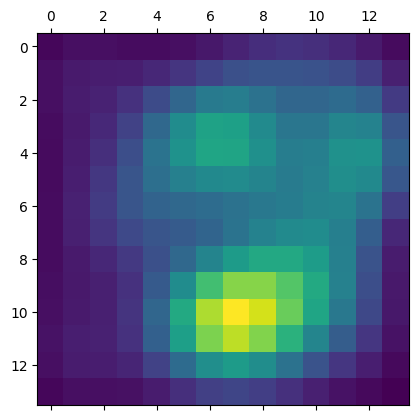

In [ ]:
# get the gradient of the output with respect to the parameters of the model
from matplotlib import pyplot as plt

pred[:, label].backward() #second index for the category its in

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = heatmap.cpu()
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [ ]:
import cv2
img = np.array(img.cpu())
img = img / np.max(img)
heatmap = np.array(heatmap)
img = np.squeeze(np.transpose(img,[2,3,1,0]))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


In [ ]:
superimposed_img = heatmap * 0.5 + img * 150
cv2.imwrite('map.jpg', superimposed_img)

True